<center><h1>Wong_Jonathan_HW5</h1></center>
<br>
<br>

Name: Jonathan Wong
<br>
Github Username: jonathanwong150
<br>
USC ID: 9171949586

## 1. Decision Trees as Interpretable Models

Import packages

In [118]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

### (a) Obtain Data

Get the Accute Inamations Data Set

In [119]:
data = '../data/hw5_data/diagnosis.data'

columns = ['Temperature', 'Nausea', 'LumbarPain', 'UrinePushing', 'MicturitionPains', 'Burning', 'Inflammation', 'Nephritis']

data = []
with open('../data/hw5_data/diagnosis.data', 'r', encoding='utf-16le') as f:
    for line in f:
        line = line.replace('\ufeff', '')
        # Split by tab then by space
        items = line.strip().split('\t')
        items = [sub.strip() for item in items for sub in item.split()]
        data.append(items)

df = pd.DataFrame(data, columns=columns)

# Convert temperature to float and label encode the categorical variables
df['Temperature'] = df['Temperature'].str.replace(',', '.').astype(float)
label_encoder = LabelEncoder()
for col in columns[1:]:
    df[col] = label_encoder.fit_transform(df[col])

print(df)

     Temperature  Nausea  LumbarPain  UrinePushing  MicturitionPains  Burning  \
0           35.5       0           1             0                 0        0   
1           35.9       0           0             1                 1        1   
2           35.9       0           1             0                 0        0   
3           36.0       0           0             1                 1        1   
4           36.0       0           1             0                 0        0   
..           ...     ...         ...           ...               ...      ...   
115         41.4       0           1             1                 0        1   
116         41.5       0           0             0                 0        0   
117         41.5       1           1             0                 1        0   
118         41.5       0           1             1                 0        1   
119         41.5       0           1             1                 0        1   

     Inflammation  Nephriti

### (b) Build a decision tree

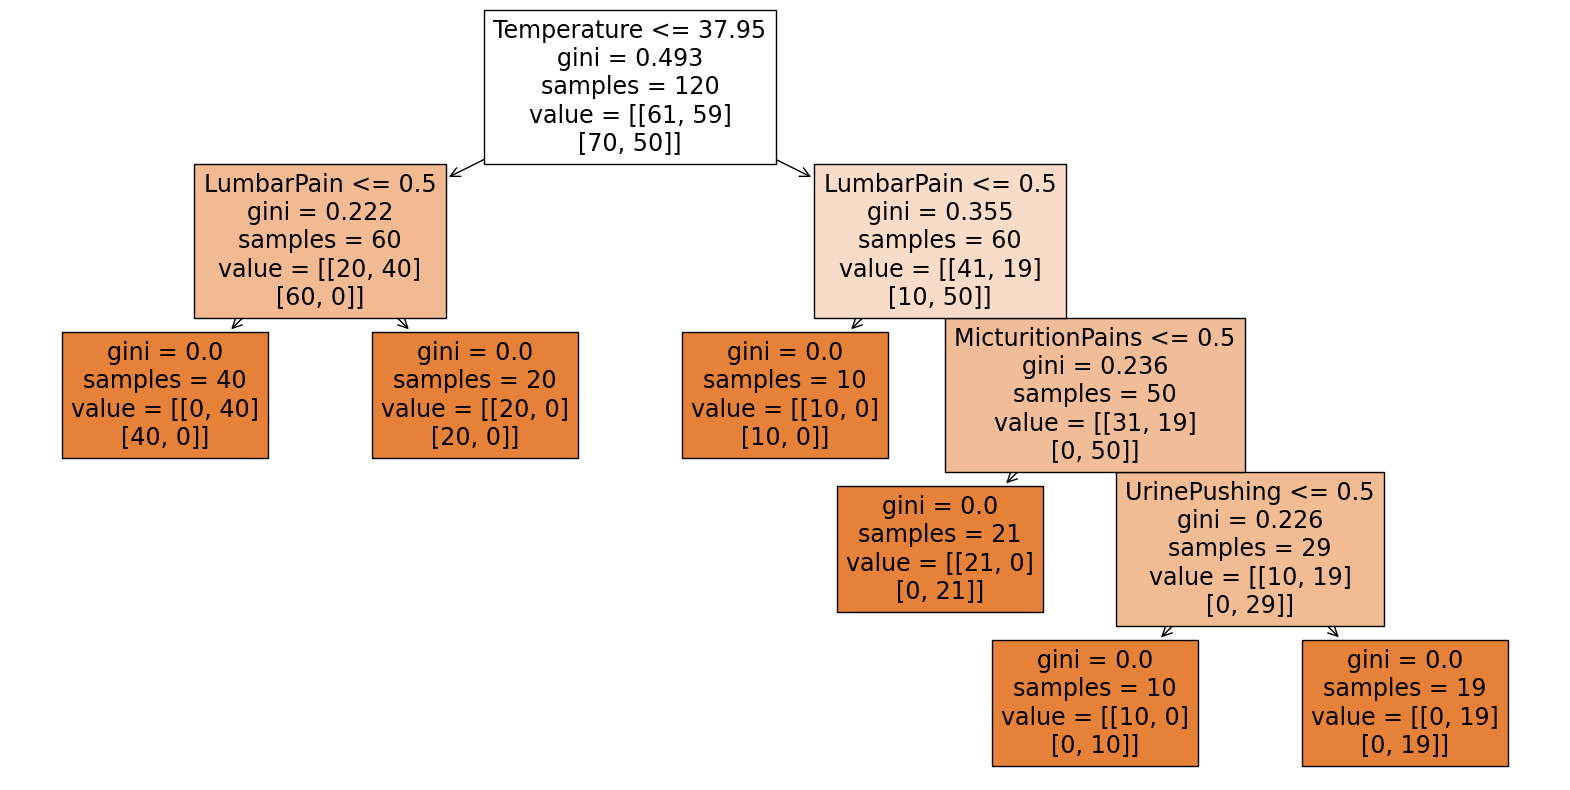

In [120]:
x = df.iloc[:, :-2]
y = df.iloc[:, -2:]

classifier = DecisionTreeClassifier()
classifier.fit(x, y)

plt.figure(figsize=(20, 10))
plot_tree(classifier, filled=True, feature_names=columns[:-2], class_names=['No', 'Yes'])
plt.show()

### (c) Convert the decision rules

In [121]:
trainX = df.iloc[:, 0:6]
trainY = df.iloc[:, 6:]
trainY = trainY.astype('int')

classifier = DecisionTreeClassifier()
classifier.fit(trainX, trainY)

def treeCode(tree, feature_names):
    tree_ = tree.tree_
    featName = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = featName[node]
            threshold = tree_.threshold[node]
            print(f"{indent}if {name} <= {threshold}:")
            recurse(tree_.children_left[node], depth + 1)
            print(f"{indent}else:  # if {name} > {threshold}")
            recurse(tree_.children_right[node], depth + 1)
        else:
            print(f"{indent}return {tree_.value[node]}")

    recurse(0, 1)

treeCode(classifier, df.columns[0:6])

  if Temperature <= 37.95000076293945:
    if LumbarPain <= 0.5:
      return [[ 0. 40.]
 [40.  0.]]
    else:  # if LumbarPain > 0.5
      return [[20.  0.]
 [20.  0.]]
  else:  # if Temperature > 37.95000076293945
    if LumbarPain <= 0.5:
      return [[10.  0.]
 [10.  0.]]
    else:  # if LumbarPain > 0.5
      if Nausea <= 0.5:
        return [[21.  0.]
 [ 0. 21.]]
      else:  # if Nausea > 0.5
        if UrinePushing <= 0.5:
          return [[10.  0.]
 [ 0. 10.]]
        else:  # if UrinePushing > 0.5
          return [[ 0. 19.]
 [ 0. 19.]]


### (d) Cost-complexity pruning to find a minimal decision tree

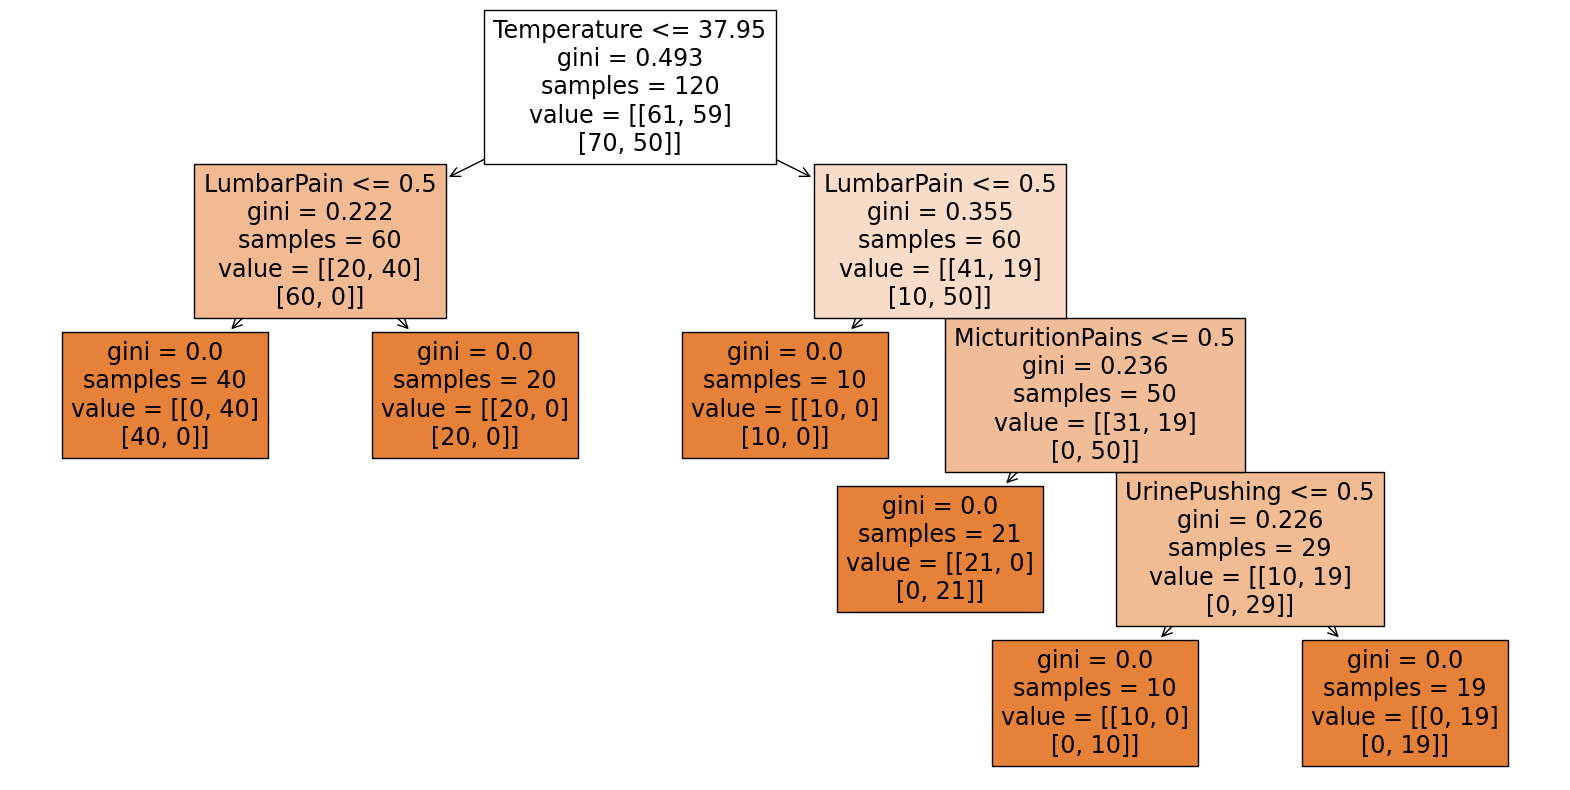


Rules from the pruned tree:
  if Temperature <= 37.95000076293945:
    if LumbarPain <= 0.5:
      return [[ 0. 40.]
 [40.  0.]]
    else:  # if LumbarPain > 0.5
      return [[20.  0.]
 [20.  0.]]
  else:  # if Temperature > 37.95000076293945
    if LumbarPain <= 0.5:
      return [[10.  0.]
 [10.  0.]]
    else:  # if LumbarPain > 0.5
      if MicturitionPains <= 0.5:
        return [[21.  0.]
 [ 0. 21.]]
      else:  # if MicturitionPains > 0.5
        if UrinePushing <= 0.5:
          return [[10.  0.]
 [ 0. 10.]]
        else:  # if UrinePushing > 0.5
          return [[ 0. 19.]
 [ 0. 19.]]


In [134]:
params = {'ccp_alpha': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]}

gridSearch = GridSearchCV(DecisionTreeClassifier(), params, cv=5)
gridSearch.fit(x, y)

# Get the best estimator and plot
bestClassifier = gridSearch.best_estimator_
plt.figure(figsize=(20, 10))
plot_tree(bestClassifier, filled=True, feature_names=columns[:-2], class_names=['No', 'Yes'])
plt.show()

# Extract IF-THEN rules from pruned tree
print("\nRules from the pruned tree:")
treeCode(bestClassifier, columns[:-2])

## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [123]:
df = pd.read_csv('../data/hw5_data/communities.data', header=None)

# Drop non-predictive features
df = df.drop(columns=[0, 1, 2, 3, 4])

# Replace '?'
df.replace('?', pd.NA, inplace=True)

trainDf, testDf = df.iloc[:1495, :], df.iloc[1495:, :]

print(trainDf.shape, testDf.shape)

(1495, 123) (499, 123)


### (b) Missing values

In [137]:
trainDf = trainDf.apply(pd.to_numeric, errors='coerce')
testDf = testDf.apply(pd.to_numeric, errors='coerce')

# Handle missing values with mean imputation
imputer = SimpleImputer(strategy='mean')
trainDfImputed = pd.DataFrame(imputer.fit_transform(trainDf))
testDfImputed = pd.DataFrame(imputer.transform(testDf))

xTrain = trainDfImputed.iloc[:, :-1]
yTrain = trainDfImputed.iloc[:, -1]
xTest = testDfImputed.iloc[:, :-1]
yTest = testDfImputed.iloc[:, -1]

print(xTrain.shape, yTrain.shape, xTest.shape, yTest.shape)

(1495, 122) (1495,) (499, 122) (499,)


### (c) Plot a correlation matrix

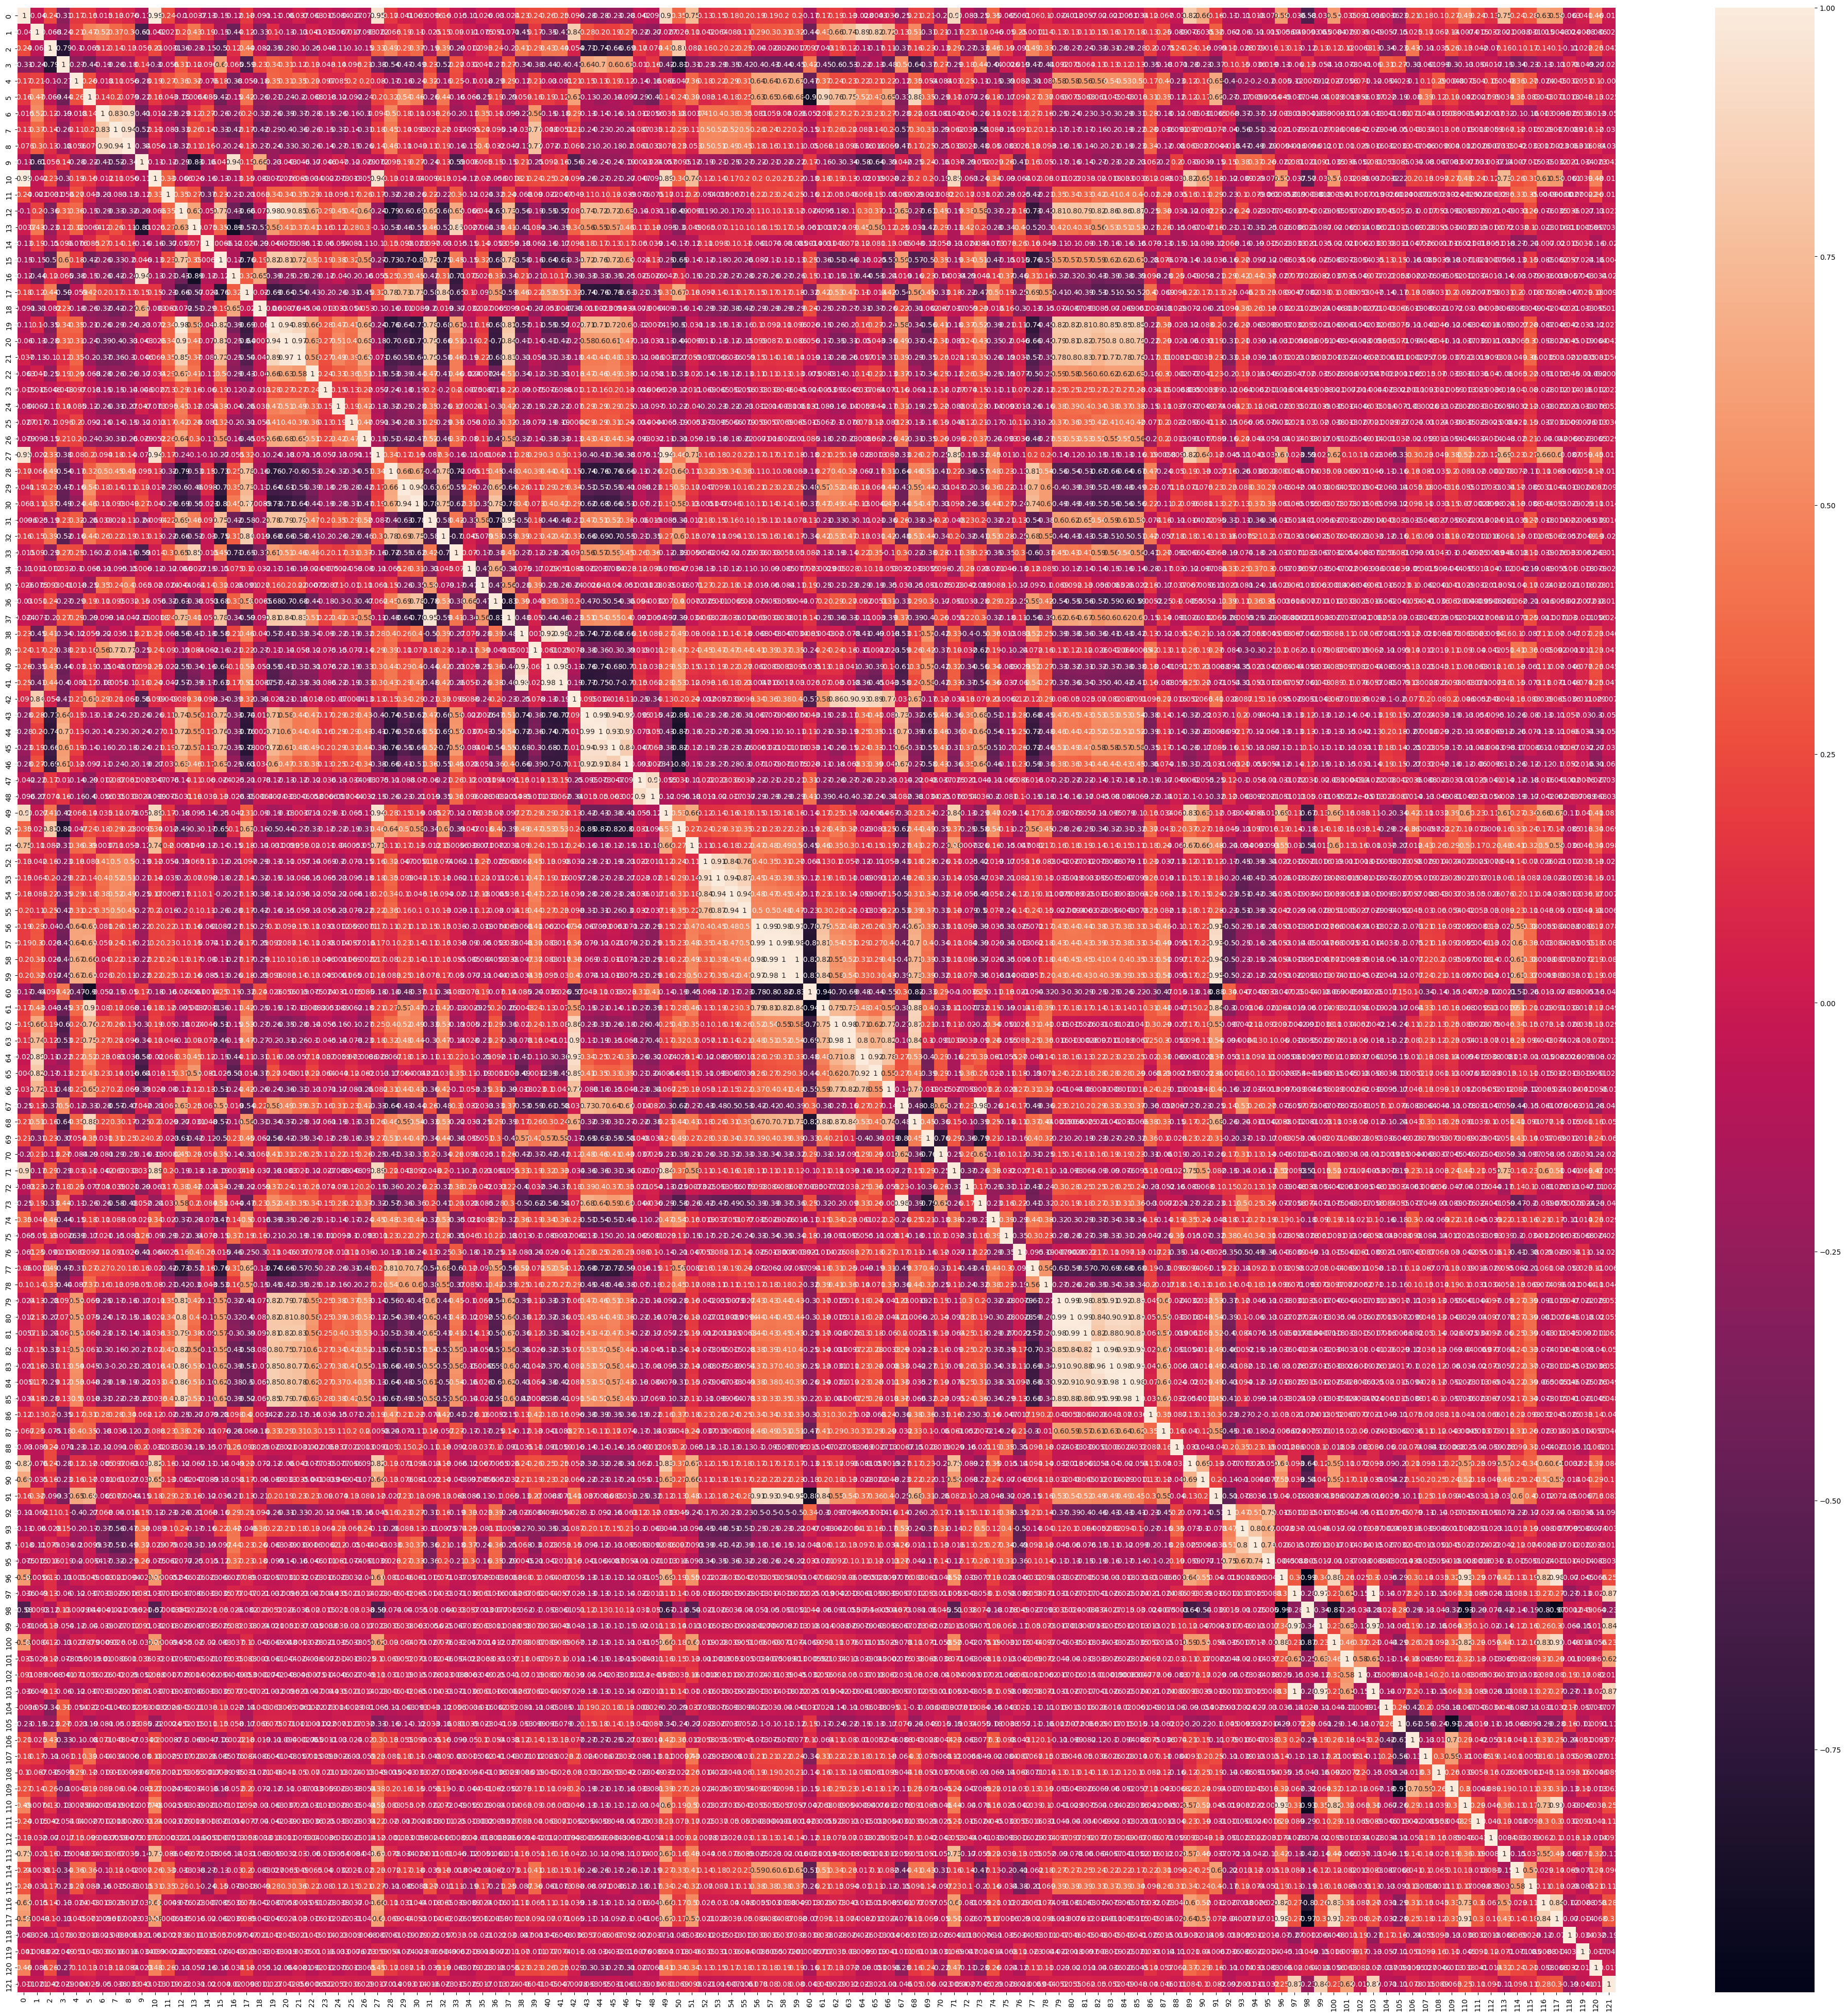

In [125]:
# Calculate the correlation matrix
corr = xTrain.corr()

# Plot the heatmap
plt.figure(figsize=(50, 50))
sns.heatmap(corr, annot=True)
plt.show()

### (d) Calculate the Coefficient of Variation CV

In [126]:
cv = xTrain.std() / xTrain.mean()
print(cv)

0      2.241105
1      0.355800
2      1.428885
3      0.330213
4      1.359100
         ...   
117    0.743487
118    0.115739
119    0.362989
120    2.552946
121    0.326026
Length: 122, dtype: float64


### (e) Scatter plots and box plots for highest CV features

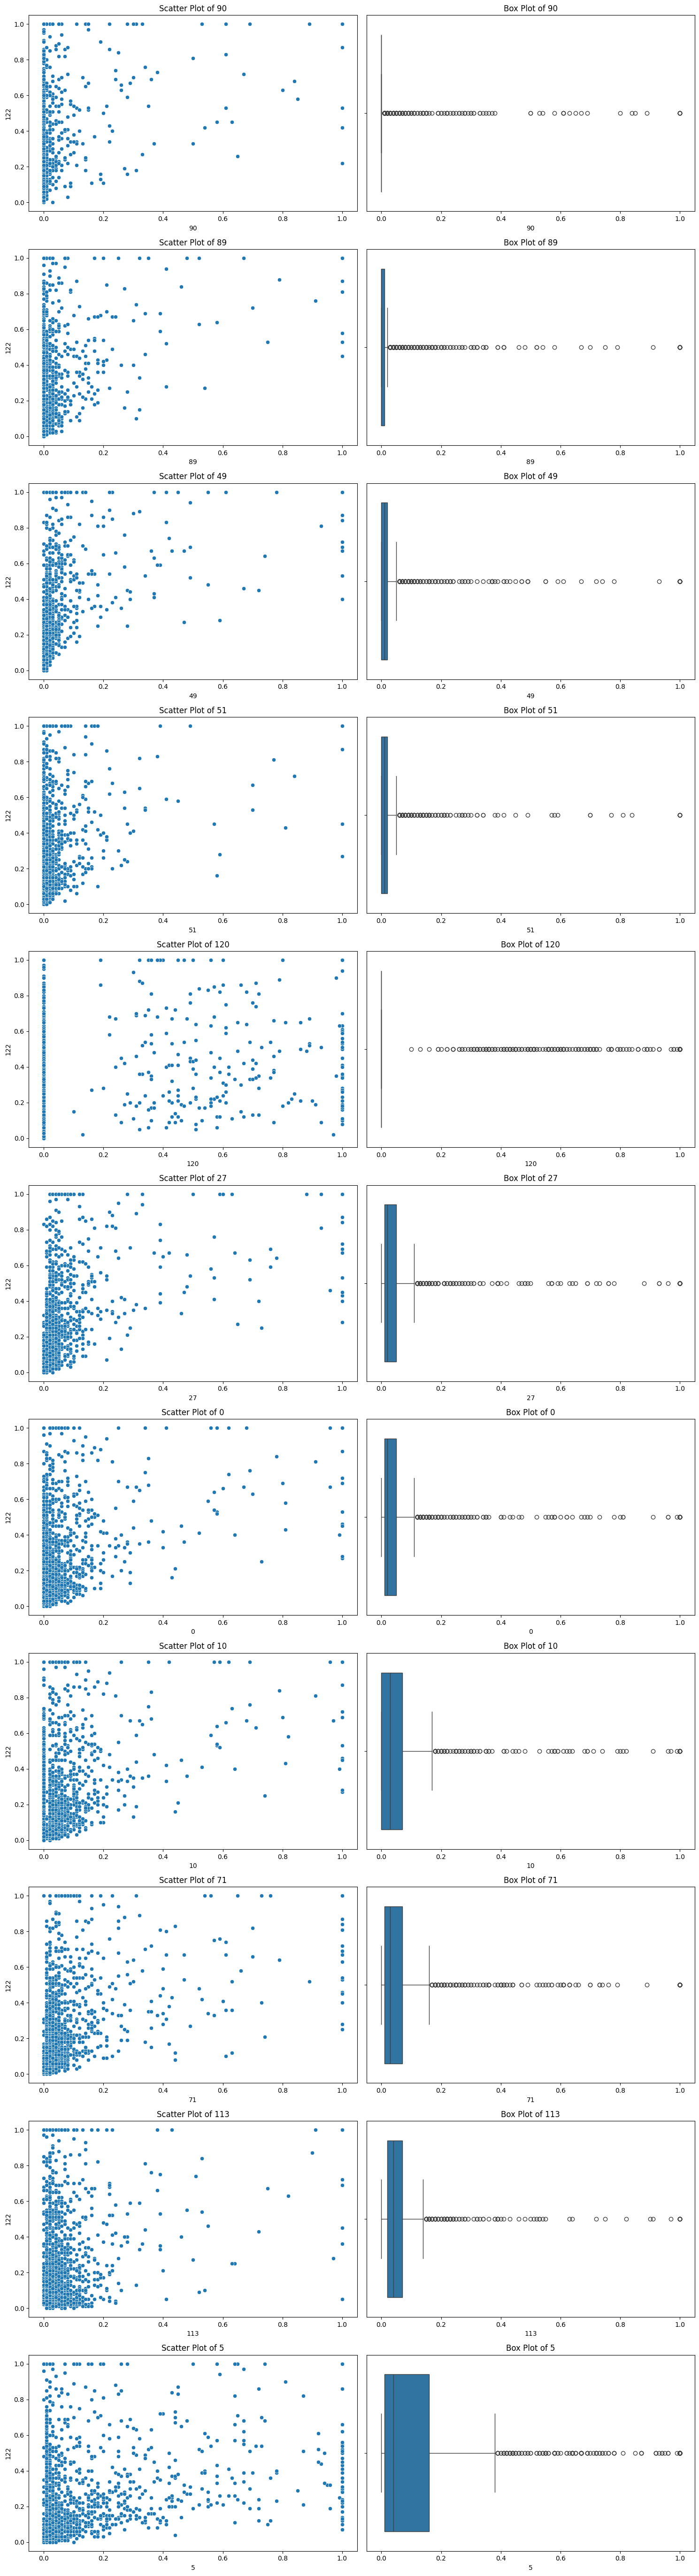

In [127]:
selectedFeats = cv.nlargest(n=int(np.floor(np.sqrt(128)))).index

# Create subplots
fig, axes = plt.subplots(len(selectedFeats), 2, figsize=(15, len(selectedFeats) * 5))

for i, feature in enumerate(selectedFeats):
    featName = xTrain.columns[feature]
    
    # Scatter plot
    sns.scatterplot(x=featName, y=yTrain, data=xTrain, ax=axes[i, 0])
    axes[i, 0].set_title(f'Scatter Plot of {featName}')
    
    # Box plot
    sns.boxplot(x=featName, data=xTrain, ax=axes[i, 1])
    axes[i, 1].set_title(f'Box Plot of {featName}')

plt.tight_layout()
plt.show()

The scatteplots are not super useful and rather variable so no conclusion can be drawn solely from them. However, the box plot combined with the scatter plots give us a general idea of trends.

### (f) Fit a linear model

In [128]:
# Fit model
linearModel = LinearRegression()
linearModel.fit(xTrain, yTrain)

# Calculate test error
yPred = linearModel.predict(xTest)
testError = mean_squared_error(yTest, yPred)
print(f"Test error (Linear Regression): {testError}")

Test error (Linear Regression): 1.809991834183255e+16


### (g) Fit a ridge regression model

In [129]:
# Define alphas 
alphas = np.logspace(-6, 6, 13)

# Fit Ridge model
ridgeModel = RidgeCV(alphas=alphas, store_cv_values=True)
ridgeModel.fit(xTrain, yTrain)

yPred = ridgeModel.predict(xTest)
testError = mean_squared_error(yTest, yPred)
print(f"Test error (Ridge Regression): {testError}")

Test error (Ridge Regression): 0.017732474992899972


### (h) Fit a LASSO model

In [130]:
# Fit LASSO model
lasso = LassoCV(alphas=alphas, cv=5)
lasso.fit(xTrain, yTrain)

# Calculate test error
yPred = lasso.predict(xTest)
testError = mean_squared_error(yTest, yPred)
print(f"Test error (LASSO): {testError}")

selectedVars = np.where(lasso.coef_ != 0)[0]
print(f"Variables selected by LASSO: {selectedVars}")

# Standardize features
scaler = StandardScaler()
xTrainScaled = scaler.fit_transform(xTrain)
xTestScaled = scaler.transform(xTest)

# Fit LASSO model on scaled data
lassoScaled = LassoCV(alphas=alphas, cv=5)
lassoScaled.fit(xTrainScaled, yTrain)

# Calculate test error
yPredScaled = lassoScaled.predict(xTestScaled)
testErrorScaled = mean_squared_error(yTest, yPredScaled)
print(f"Test error (LASSO with standardized features): {testErrorScaled}")  

Test error (LASSO): 0.01778608951910212
Variables selected by LASSO: [  2   4   6   7   9  11  13  14  15  16  17  18  21  22  23  24  25  26
  28  29  31  33  34  36  38  39  40  44  45  46  48  49  50  51  55  59
  61  63  64  67  68  69  70  71  72  74  75  76  77  78  79  82  85  86
  87  88  89  90  91  94  99 100 102 104 105 106 107 108 110 111 112 113
 114 115 116 118 119 120]
Test error (LASSO with standardized features): 0.017758149260213713


### (i) Fit a PCR model

In [131]:
pca = PCA()
xTrainPCA = pca.fit_transform(xTrainScaled)

# Cross-validation to select M
cvScores = []
for i in range(1, xTrainPCA.shape[1] + 1):
    score = -cross_val_score(LinearRegression(), xTrainPCA[:, :i], yTrain, cv=5, scoring='neg_mean_squared_error').mean()
    cvScores.append(score)

M = np.argmin(cvScores) + 1

# Fit PCR model
linearPCR = LinearRegression()
linearPCR.fit(xTrainPCA[:, :M], yTrain)

xTestPCA = pca.transform(xTestScaled)
yPredPCR = linearPCR.predict(xTestPCA[:, :M])
testErrorPCR = mean_squared_error(yTest, yPredPCR)
print(f"Test error (PCR): {testErrorPCR}")

Test error (PCR): 0.01839293123038779


### (j) Fit a boosting tree

In [138]:
params = {'alpha': np.logspace(-3, 3, 7)}

# Create XGBoost model
xbgModel = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree')

gridSearch = GridSearchCV(xbgModel, params, cv=5, scoring='neg_mean_squared_error')
gridSearch.fit(xTrain, yTrain)

# Best alpha
bestAlpha = gridSearch.best_params_['alpha']
print(bestAlpha)

# Fit model with best alpha
xgbBest = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree', alpha=bestAlpha)
xgbBest.fit(xTrain, yTrain)

# Test error
yPred = xgbBest.predict(xTest)
testError = mean_squared_error(yTest, yPred)
print(f"Test error (L1-Penalized Gradient Boosting Tree): {testError}")

1.0
Test error (L1-Penalized Gradient Boosting Tree): 0.017747461401957192
